In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from statsmodels.formula import api as smf

In [2]:
path_data = "../dataset/"
buoys_df = pd.read_csv(f"{path_data}prepared_buoy_data.csv", index_col=[0, 1])

kvs_10 = buoys_df.loc['KVS_SvalMIZ_10'].dropna()
kvs_10_index = np.array(kvs_10.index.values)
kvs_10_t1m = np.array(kvs_10['temp_air'].values)
kvs_10_t2m = np.array(kvs_10['arome_t2m'].values)

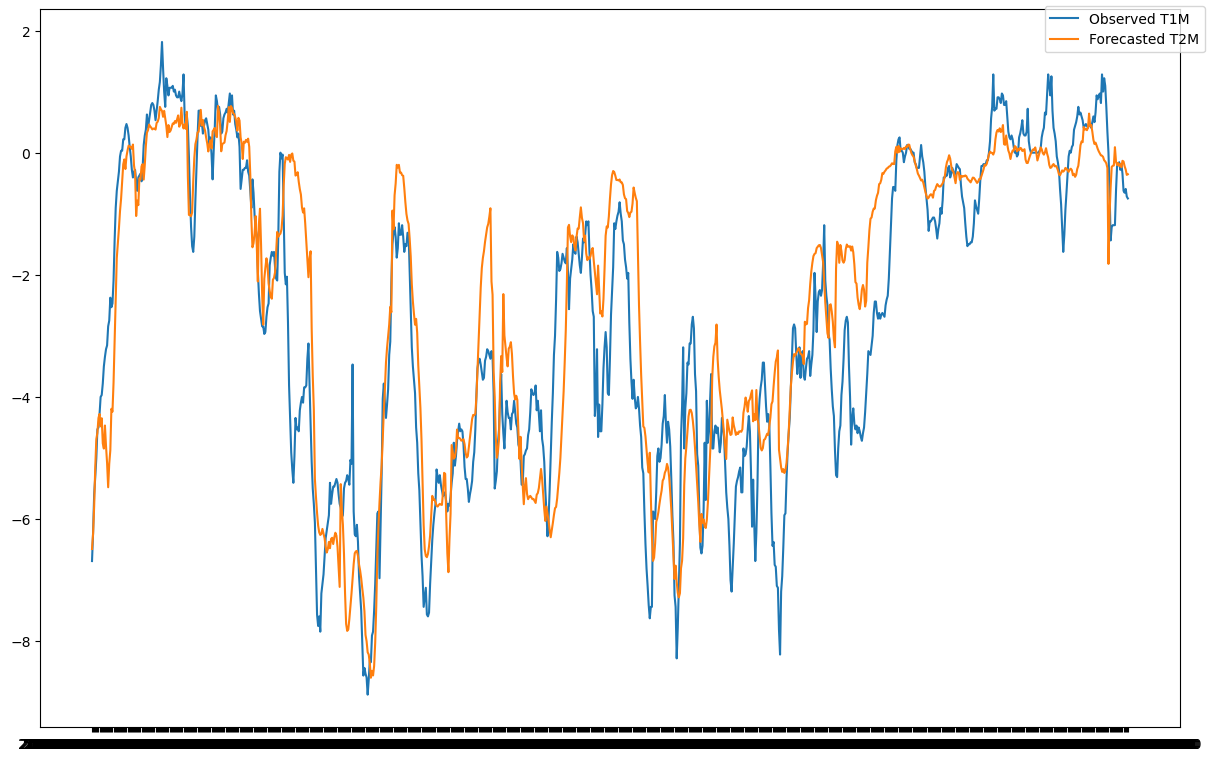

In [3]:
fig, ax = plt.subplots(figsize = (12, 7.5), constrained_layout = True)

ax.plot(kvs_10_index, kvs_10_t1m, label = 'Observed T1M')
ax.plot(kvs_10_index, kvs_10_t2m, label = 'Forecasted T2M')

fig.legend()

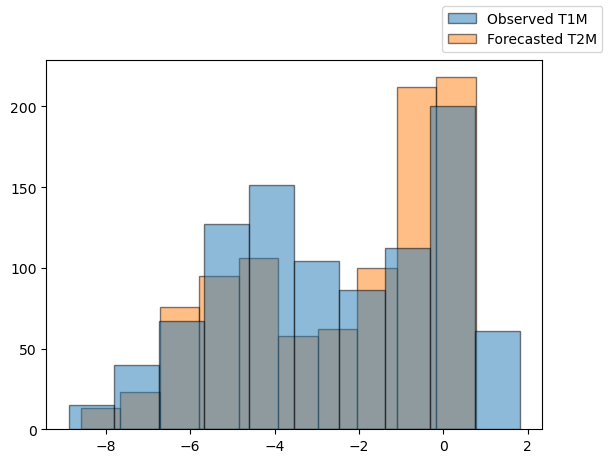

In [4]:
fig, ax = plt.subplots()

ax.hist(kvs_10_t1m, alpha = 0.5, edgecolor = 'black', label = 'Observed T1M')
ax.hist(kvs_10_t2m, alpha = 0.5, edgecolor = 'black', label = 'Forecasted T2M', zorder = 0)

fig.legend()

#### Do a linear regression baseline statistical correction model

Build model using forward selection principles

In [5]:
def partial_corr(df_corr, y, x1, x2):
    return (df_corr.loc[y][x2] - df_corr[y][x1] * df_corr[x2][x1]) / (np.sqrt(1 - df_corr.loc[x2][x1]**2)*np.sqrt(1 - df_corr.loc[y][x1]**2))

In [6]:
buoy_10_corr = kvs_10.corr()
print(buoy_10_corr.loc['temp_air'])

lat             -0.205629
lon             -0.603520
arome_t2m        0.878030
temp_air         1.000000
temp_surf        0.784072
temp_snow_ice    0.501080
temp_ice        -0.090294
sic              0.096589
Name: temp_air, dtype: float64


Start off with a univariate regression model using T2M as predictor

In [7]:
buoy_10_ols1 = smf.ols('temp_air ~ arome_t2m', data = kvs_10).fit()
print(buoy_10_ols1.summary())

                            OLS Regression Results                            
Dep. Variable:               temp_air   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     3234.
Date:                Fri, 07 Nov 2025   Prob (F-statistic):          8.44e-310
Time:                        14:23:24   Log-Likelihood:                -1551.9
No. Observations:                 963   AIC:                             3108.
Df Residuals:                     961   BIC:                             3118.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5251      0.055     -9.630      0.0

In [8]:
rylatarome = partial_corr(buoy_10_corr, 'temp_air', 'arome_t2m', 'lat')
print(f"{rylatarome=}")

rylonarome = partial_corr(buoy_10_corr, 'temp_air', 'arome_t2m', 'lon')
print(f"{rylonarome=}")

rysurfarome = partial_corr(buoy_10_corr, 'temp_air', 'arome_t2m', 'temp_surf')
print(f"{rysurfarome=}")

rysiarome = partial_corr(buoy_10_corr, 'temp_air', 'arome_t2m', 'temp_snow_ice')
print(f"{rysiarome=}")

rysicarome = partial_corr(buoy_10_corr, 'temp_air', 'arome_t2m', 'sic')
print(f"{rysicarome=}")

rylatarome=np.float64(-0.0814636756628349)
rylonarome=np.float64(-0.32543629463217744)
rysurfarome=np.float64(0.6598259362797029)
rysiarome=np.float64(0.09172625391803932)
rysicarome=np.float64(0.12726304718785)


Based on partial correlations, temp_surf is entered into the model, however it is noted that in practice this variable might not make too much since it requires an additional obersvation, can not be applied to AA in real time

In [9]:
buoy_10_ols2 = smf.ols(formula = 'temp_air ~ arome_t2m + temp_surf', data = kvs_10).fit()
print(buoy_10_ols2.summary())

                            OLS Regression Results                            
Dep. Variable:               temp_air   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     3231.
Date:                Fri, 07 Nov 2025   Prob (F-statistic):               0.00
Time:                        14:23:24   Log-Likelihood:                -1276.7
No. Observations:                 963   AIC:                             2559.
Df Residuals:                     960   BIC:                             2574.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0815      0.046    -23.608      0.0

Also make one model with the available lat/lon data, as well as sic?

In [10]:
buoy_10_ols_sic = smf.ols(formula = 'temp_air ~ arome_t2m + sic', data = kvs_10).fit()
print(buoy_10_ols_sic.summary())

                            OLS Regression Results                            
Dep. Variable:               temp_air   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     1650.
Date:                Fri, 07 Nov 2025   Prob (F-statistic):          2.37e-311
Time:                        14:23:24   Log-Likelihood:                -1544.1
No. Observations:                 963   AIC:                             3094.
Df Residuals:                     960   BIC:                             3109.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.6798      0.545     -4.920      0.0

In [11]:
buoy_10_ols_latlon = smf.ols(formula = 'temp_air ~ arome_t2m + lat + lon', data = kvs_10).fit()
print(buoy_10_ols_latlon.summary())

                            OLS Regression Results                            
Dep. Variable:               temp_air   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     1283.
Date:                Fri, 07 Nov 2025   Prob (F-statistic):               0.00
Time:                        14:23:24   Log-Likelihood:                -1485.3
No. Observations:                 963   AIC:                             2979.
Df Residuals:                     959   BIC:                             2998.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -45.1383      9.125     -4.947      0.0

In [12]:
intercept, slope = buoy_10_ols1.params

corrected_t2m = intercept + kvs_10['arome_t2m'] * slope


intercept, slope1, slope2 = buoy_10_ols2.params

corrected_t2m_2 = intercept + kvs_10['arome_t2m'] * slope1 + kvs_10['temp_surf'] * slope2


intercept, slope1, slope2 = buoy_10_ols_sic.params

corrected_t2m_sic = intercept + kvs_10['arome_t2m'] * slope1 + kvs_10['sic'] * slope2

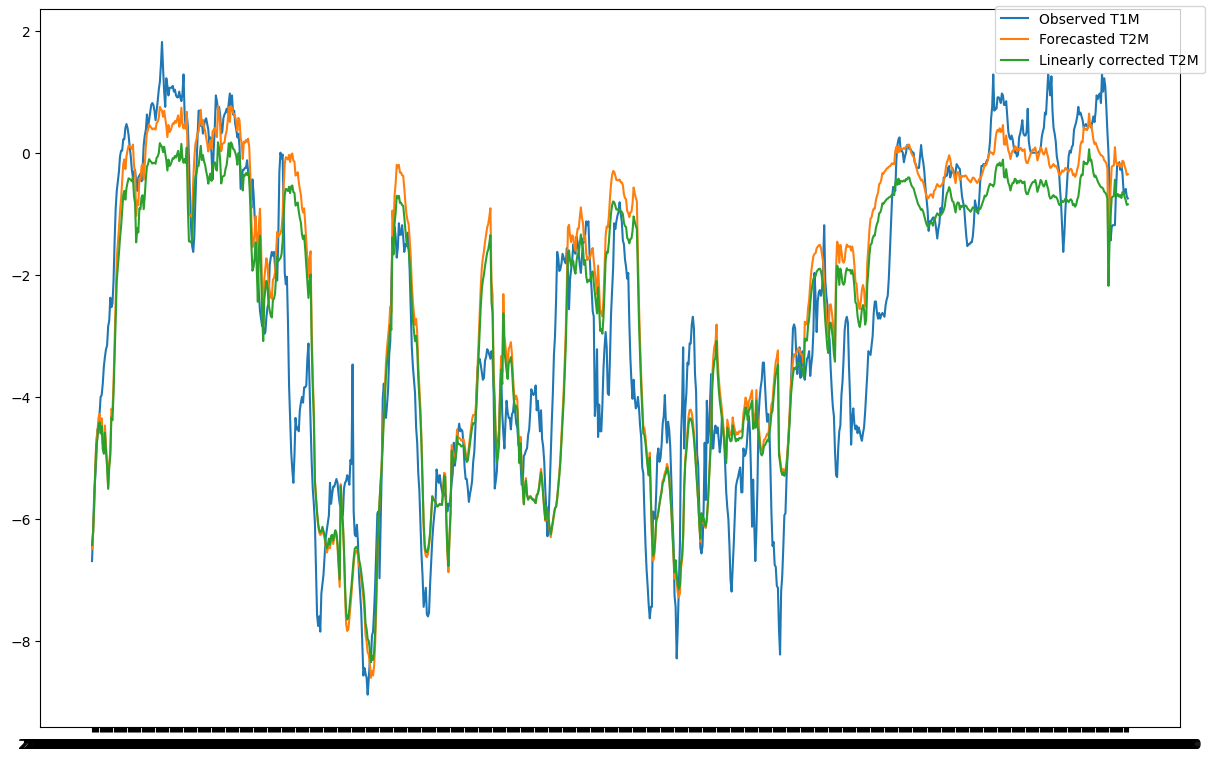

In [16]:
fig, ax = plt.subplots(figsize = (12, 7.5), constrained_layout = True)

ax.plot(kvs_10_index, kvs_10_t1m, label = 'Observed T1M')
ax.plot(kvs_10_index, kvs_10_t2m, label = 'Forecasted T2M')
ax.plot(kvs_10_index, corrected_t2m, label = 'Linearly corrected T2M')
# ax.plot(kvs_10_index, corrected_t2m_2, label = 'temp_surf corrected T2M')
# ax.plot(kvs_10_index, corrected_t2m_sic, label = 'sic corrected T2M')

fig.legend()

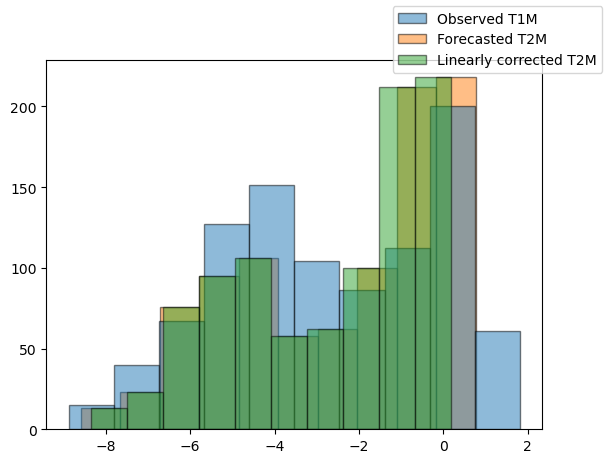

In [15]:
fig, ax = plt.subplots()

ax.hist(kvs_10_t1m, alpha = 0.5, edgecolor = 'black', label = 'Observed T1M')
ax.hist(kvs_10_t2m, alpha = 0.5, edgecolor = 'black', label = 'Forecasted T2M', zorder = 0)
ax.hist(corrected_t2m, alpha = 0.5, edgecolor = 'black', label = 'Linearly corrected T2M')
# ax.hist(corrected_t2m_2, alpha = 0.5, edgecolor = 'black', label = 'Multivariate Linearly corrected T2M')
# ax.hist(corrected_t2m_sic, alpha = 0.5, edgecolor = 'black', label = 'Sic corrected T2M')

fig.legend()